In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('seaborn')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

result_path = 'C:\\Users\\oli-w\\OneDrive\\Uni\\Master Thesis\\Neural-Network-Option-Pricing-Master-Thesis\\Code\\Results\\'
plot_path = 'C:\\Users\\oli-w\\OneDrive\\Uni\\Master Thesis\\LaTeX Template\\'

In [2]:
T = [0.3, 1, 3]

In [3]:
"""
Function to plot MSE vs. network size for Merton JD model data (left) and NIG model data (right)
dim: 'one', 'two', 'thirty'
error: 'Validation' to plot average MSE from grid search, 'Test' to plot MSE on test set
"""

def plot_overview_generated_data(result_dict, dim='one', error='Validation'):
    fig, axes = plt.subplots(1, 2, figsize=(6,2.5), sharex=True, sharey=True)
    fig.tight_layout()
    for ax, pricer in zip(axes, ['merton', 'nig']):
        res = result_dict[pricer]
        for t, c in zip(T, ['0.3', '0.5', '0.7']):
            ax.plot(res[t]['Weights'], res[t]['{} MSE'.format(error)], '-o', c=c, mfc=c, mec=c, markersize=4, lw=1,
                    label='$T = {}$'.format(t))
        ax.plot(res[1]['Weights'], 1 / res[1]['Weights'], c='navy', lw=1, label='$M(\phi)^{-1}$')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlabel('Number of Weights')
        handles, labels = axes[1].get_legend_handles_labels()
        ax.tick_params(axis='both', which='major', labelsize=8)
    axes[0].set_ylabel('{} MSE'.format(error))
    fig.legend(handles, labels, loc=[0.3,0.94], ncol=4, prop={'size': 6})
    plt.tight_layout()
    plt.savefig(plot_path + '{}_dim_nig_merton_{}_results.pdf'.format(dim, error.lower()))

In [4]:
"""
Function to load result data for given dimension
gs_results: overview obtained from grid search
test_results: overview obtained from tests on hold-out set
"""

def load_overviews_generated_data(dim='one'):
    T = [0.3, 1, 3]
    gs_results = {}
    test_results = {}
    for pricer in ['merton', 'nig']:
        gs_results[pricer] = {}
        test_results[pricer] = {}
        for t in T:
            gs_results[pricer][t] = pd.read_csv(result_path + '{}_dim_{}_{}_grid_search_overview.csv'.format(dim, pricer, t))
            test_results[pricer][t] = pd.read_csv(result_path + '{}_dim_{}_{}_test_overview.csv'.format(dim, pricer, t))
    return gs_results, test_results

In [5]:
"""
Creates a dataframe with train/test results averaged over all pricing models and maturities for the best models
with each 1, 2 or 3 hidden layers
"""

def get_averaged_overviews(pricer_list=['merton', 'nig'], dim='one', T=[0.3, 1, 3]):
    res_avg = {}
    for hidden in [1, 2, 3]:
        dfs = []
        for pricer in pricer_list:
            for t in T:
                df = pd.read_csv(result_path + '{}_dim_{}_{}_test_all_hidden.csv'.format(dim, pricer, t))
                dfs.append(df[df['Hidden Layers'] == hidden])
        df = pd.concat(dfs).groupby('Weights').mean().reset_index()
        res_avg[hidden] = df[['Weights', 'Test MSE', 'Training Time (s)']]
    return res_avg

In [6]:
"""
Plots the Test MSE and training time averaged over all pricing models and maturities for each number of hidden layers
"""

def plot_averaged_training(res_avg_dict, dim='one', data='generated'):
    fig, axes = plt.subplots(1, 2, figsize=(6,2.5))
    fig.tight_layout()
    for hidden, c in zip([1, 2, 3], ['0.3', '0.5', '0.7']):
        axes[0].plot(res_avg_dict[hidden]['Weights'], res_avg_dict[hidden]['Test MSE'], '-o', c=c, mfc=c, mec=c,
                     markersize=4, lw=1, label='$L-1 = {}$'.format(hidden))
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')
    axes[0].legend()
    labels = list(res_avg[1]['Weights'])
    x = np.arange(len(labels))
    width = 0.25
    for hidden, c, offset in zip([1, 2, 3], ['0.3', '0.5', '0.7'], [-width, 0, width]):
        axes[1].bar(x + offset, res_avg[hidden]['Training Time (s)'], width, color=c, label='$L-1 = {}$'.format(hidden))
    axes[1].legend()
    tick_weights = [10, 100, 1000, 10000]
    tick_format = ['$10^1$', '$10^2$', '$10^3$', '$10^4$']
    if dim != 'one':
        tick_weights = tick_weights[1:]
        tick_format = tick_format[1:]
    xticks = [labels.index(w) for w in tick_weights]
    axes[1].set_xticks(xticks)
    axes[1].set_xticklabels(tick_format)
    for ax, col in zip(axes, ['Test MSE', 'Training Time (s)']):
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_xlabel('Number of Weights')
        ax.set_title(col)
    plt.tight_layout()
    plt.savefig(plot_path + '{}_dim_training_results_{}.pdf'.format(dim, data))

In [7]:
"""
Formatting result dataframes for latex
"""

def result_to_latex(result_df, resize=True):
    for mse in ['Test MSE', 'Validation MSE']:
        if mse in result_df.columns:
            result_df[mse] = result_df[mse].apply(lambda x: '{:.2e}'.format(x)).apply(lambda x: '\num{' + x + '}')
    if 'Training Time (s)' in result_df.columns:
        result_df['Training Time (s)'] = result_df['Training Time (s)'].apply(lambda x: '{:.2f}'.format(x))
    if 'Learning Rate' in result_df.columns:
        result_df['Learning Rate'] = result_df['Learning Rate'].apply(lambda x: '{:g}'.format(x))
    s = result_df.to_latex(escape=False, index=False, column_format='r|' + 'l' * (len(result_df.columns) - 1))
    if resize:
        print('\\centering\n\\resizebox{\\columnwidth}{!}{%\n' + s + '%\n}')
    else:
        print('\\centering\n' + s)

# 1 One-dim Generated Data

In [8]:
# Load grid search and test overviews for all data sets

gs_res, test_res = load_overviews_generated_data('one')

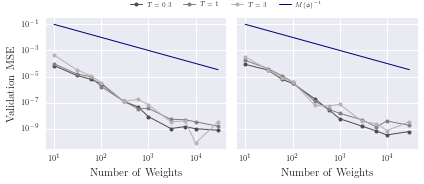

In [9]:
# Plot performance of best models from grid search

plot_overview_generated_data(gs_res, 'one', 'Validation')

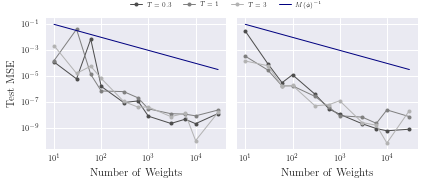

In [10]:
# Plot performance of best models on test set

plot_overview_generated_data(test_res, 'one', 'Test')

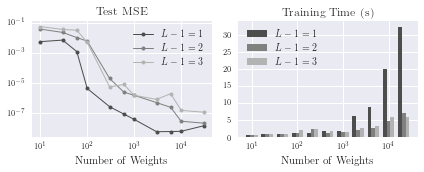

In [11]:
# Plot averaged training/test results

res_avg = get_averaged_overviews()
plot_averaged_training(res_avg)

In [12]:
# Print all results for latex

for res_dict, name in zip([gs_res, test_res], ['Validation Results', 'Test Results']):
    print(name)
    for pricer in res_dict.keys():
        print(pricer.upper() + '\n')
        for t in res_dict[pricer].keys():
            print('T = {}\n'.format(t))
            result_to_latex(res_dict[pricer][t])
            print('\n')
print('Averaged Results\n')
for hidden in [1, 2, 3]:
    print('L - 1 = {}\n'.format(hidden))
    result_to_latex(res_avg[hidden], resize=False)
    print('\n')

Validation Results
MERTON

T = 0.3

\centering
\resizebox{\columnwidth}{!}{%
\begin{tabular}{r|llllll}
\toprule
 Weights & Validation MSE &  Hidden Layers & Learning Rate &  Batch Size &  Epochs & Training Time (s) \\
\midrule
      10 & \num{6.96e-05} &              1 &           0.1 &         256 &      50 &              2.45 \\
      30 & \num{1.23e-05} &              1 &           0.1 &         128 &      25 &              2.60 \\
      60 & \num{6.08e-06} &              1 &          0.01 &         128 &      25 &              3.29 \\
     100 & \num{2.73e-06} &              1 &          0.01 &         512 &      50 &              2.39 \\
     300 & \num{1.25e-07} &              1 &          0.01 &         128 &     150 &             15.57 \\
     600 & \num{4.72e-08} &              1 &          0.01 &         128 &      20 &              3.25 \\
    1000 & \num{8.39e-09} &              1 &          0.01 &         256 &      50 &              5.47 \\
    3000 & \num{1.02e-09} &    

C:\Users\oli-w\AppData\Local\Temp/ipykernel_22452/4495397.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  s = result_df.to_latex(escape=False, index=False, column_format='r|' + 'l' * (len(result_df.columns) - 1))


\centering
\resizebox{\columnwidth}{!}{%
\begin{tabular}{r|llllll}
\toprule
 Weights &       Test MSE &  Hidden Layers & Learning Rate &  Batch Size &  Epochs (Early Stop) & Training Time (s) \\
\midrule
      10 & \num{1.27e-04} &              1 &           0.1 &         256 &                    8 &              0.54 \\
      30 & \num{6.41e-06} &              1 &           0.1 &         128 &                   22 &              1.16 \\
      60 & \num{7.24e-03} &              1 &          0.01 &         128 &                    6 &              0.64 \\
     100 & \num{1.69e-06} &              1 &          0.01 &         512 &                   29 &              0.64 \\
     300 & \num{9.65e-08} &              1 &          0.01 &         128 &                   18 &              1.19 \\
     600 & \num{1.28e-07} &              1 &          0.01 &         128 &                   16 &              1.16 \\
    1000 & \num{8.60e-09} &              1 &          0.01 &         256 &        

# 2 Two-dim Generated Data

In [13]:
# Load grid search and test overviews for all data sets

gs_res, test_res = load_overviews_generated_data('two')

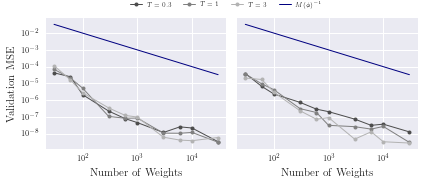

In [14]:
# Plot performance of best models from grid search

plot_overview_generated_data(gs_res, 'two', 'Validation')

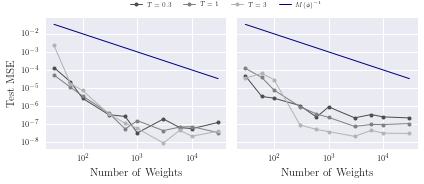

In [15]:
# Plot performance of best models on test set

plot_overview_generated_data(test_res, 'two', 'Test')

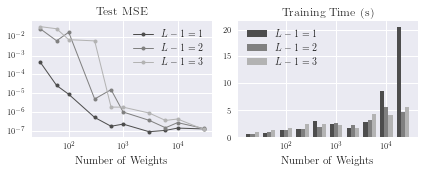

In [16]:
# Plot averaged training/test results

res_avg = get_averaged_overviews(dim='two')
plot_averaged_training(res_avg, 'two')

In [17]:
# Print all results for latex

for res_dict, name in zip([gs_res, test_res], ['Validation Results', 'Test Results']):
    print(name)
    for pricer in res_dict.keys():
        print(pricer.upper() + '\n')
        for t in res_dict[pricer].keys():
            print('T = {}\n'.format(t))
            result_to_latex(res_dict[pricer][t])
            print('\n')
print('Averaged Results\n')
for hidden in [1, 2, 3]:
    print('L - 1 = {}\n'.format(hidden))
    result_to_latex(res_avg[hidden], resize=False)
    print('\n')

Validation Results
MERTON

T = 0.3

\centering
\resizebox{\columnwidth}{!}{%
\begin{tabular}{r|llllll}
\toprule
 Weights & Validation MSE &  Hidden Layers & Learning Rate &  Batch Size &  Epochs & Training Time (s) \\
\midrule
      30 & \num{4.28e-05} &              1 &           0.1 &         128 &      10 &              2.01 \\
      60 & \num{2.49e-05} &              1 &          0.01 &         128 &      50 &              3.39 \\
     100 & \num{2.14e-06} &              1 &          0.01 &          64 &      25 &              3.03 \\
     300 & \num{2.25e-07} &              1 &          0.01 &         256 &     100 &              3.53 \\
     600 & \num{7.97e-08} &              1 &          0.01 &         256 &     150 &              5.47 \\
    1000 & \num{4.64e-08} &              1 &         0.001 &          64 &     150 &             16.22 \\
    3000 & \num{1.19e-08} &              1 &          0.01 &         256 &     150 &             12.98 \\
    6000 & \num{2.58e-08} &    

C:\Users\oli-w\AppData\Local\Temp/ipykernel_22452/4495397.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  s = result_df.to_latex(escape=False, index=False, column_format='r|' + 'l' * (len(result_df.columns) - 1))


T = 1

\centering
\resizebox{\columnwidth}{!}{%
\begin{tabular}{r|llllll}
\toprule
 Weights &       Test MSE &  Hidden Layers & Learning Rate &  Batch Size &  Epochs (Early Stop) & Training Time (s) \\
\midrule
      30 & \num{1.24e-04} &              1 &           0.1 &         512 &                   38 &              0.71 \\
      60 & \num{3.89e-05} &              1 &           0.1 &         512 &                   32 &              0.56 \\
     100 & \num{7.90e-06} &              1 &          0.01 &         256 &                   78 &              1.03 \\
     300 & \num{9.38e-07} &              1 &          0.01 &         256 &                   67 &              1.12 \\
     600 & \num{3.73e-07} &              1 &         0.001 &          64 &                   71 &              2.96 \\
    1000 & \num{2.40e-07} &              1 &          0.01 &         256 &                   53 &              0.99 \\
    3000 & \num{7.64e-08} &              1 &         0.001 &         128 & 

# 3 Thirty-dim Generated Data

In [18]:
# Load grid search and test overviews for all data sets

gs_res, test_res = load_overviews_generated_data('thirty')

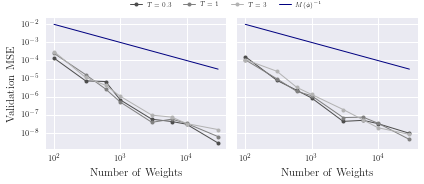

In [19]:
# Plot performance of best models from grid search

plot_overview_generated_data(gs_res, 'thirty', 'Validation')

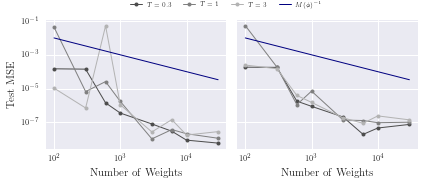

In [20]:
# Plot performance of best models on test set

plot_overview_generated_data(test_res, 'thirty', 'Test')

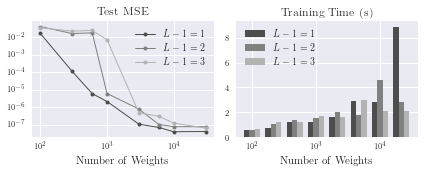

In [21]:
# Plot averaged training/test results

res_avg = get_averaged_overviews(dim='thirty')
plot_averaged_training(res_avg, 'thirty')

In [22]:
# Print all results for latex

for res_dict, name in zip([gs_res, test_res], ['Validation Results', 'Test Results']):
    print(name)
    for pricer in res_dict.keys():
        print(pricer.upper() + '\n')
        for t in res_dict[pricer].keys():
            print('T = {}\n'.format(t))
            result_to_latex(res_dict[pricer][t])
            print('\n')
print('Averaged Results\n')
for hidden in [1, 2, 3]:
    print('L - 1 = {}\n'.format(hidden))
    result_to_latex(res_avg[hidden], resize=False)
    print('\n')

Validation Results
MERTON

T = 0.3

\centering
\resizebox{\columnwidth}{!}{%
\begin{tabular}{r|llllll}
\toprule
 Weights & Validation MSE &  Hidden Layers & Learning Rate &  Batch Size &  Epochs & Training Time (s) \\
\midrule
     100 & \num{1.35e-04} &              1 &          0.01 &         512 &     100 &              2.36 \\
     300 & \num{7.47e-06} &              1 &          0.01 &          64 &      50 &              3.93 \\
     600 & \num{6.85e-06} &              1 &          0.01 &         512 &      50 &              1.97 \\
    1000 & \num{6.64e-07} &              1 &          0.01 &         128 &      50 &              3.10 \\
    3000 & \num{5.63e-08} &              1 &          0.01 &         256 &     200 &              6.08 \\
    6000 & \num{4.21e-08} &              2 &         0.001 &          64 &     100 &              9.18 \\
   10000 & \num{3.00e-08} &              2 &        0.0001 &          64 &     300 &             28.01 \\
   30000 & \num{2.72e-09} &    

C:\Users\oli-w\AppData\Local\Temp/ipykernel_22452/4495397.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  s = result_df.to_latex(escape=False, index=False, column_format='r|' + 'l' * (len(result_df.columns) - 1))


\centering
\resizebox{\columnwidth}{!}{%
\begin{tabular}{r|llllll}
\toprule
 Weights &       Test MSE &  Hidden Layers & Learning Rate &  Batch Size &  Epochs (Early Stop) & Training Time (s) \\
\midrule
     100 & \num{5.37e-02} &              1 &          0.01 &          64 &                   10 &              0.56 \\
     300 & \num{1.87e-04} &              1 &           0.1 &         512 &                   26 &              0.57 \\
     600 & \num{1.11e-06} &              1 &          0.01 &          64 &                   32 &              1.17 \\
    1000 & \num{7.05e-06} &              1 &          0.01 &         256 &                   60 &              0.92 \\
    3000 & \num{1.35e-07} &              1 &          0.01 &         512 &                  253 &              1.80 \\
    6000 & \num{1.27e-07} &              2 &         0.001 &          64 &                   66 &              2.27 \\
   10000 & \num{9.46e-08} &              2 &        0.0001 &          64 &        

# 4 Market Data

In [23]:
T = [0.33, 1.01, 1.85]
gs_results = {}
test_results = {}
for t in T:
    gs_results[t] = pd.read_csv(result_path + 'one_dim_AMZN_{}_grid_search_overview.csv'.format(t))
    test_results[t] = pd.read_csv(result_path + 'one_dim_AMZN_{}_test_overview.csv'.format(t))

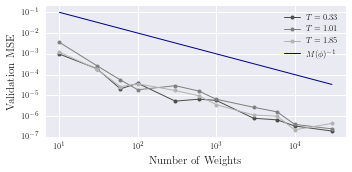

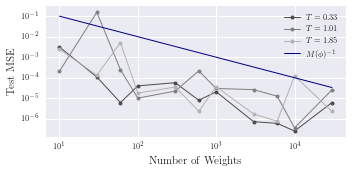

In [24]:
for res, error in zip([gs_results, test_results], ['Validation', 'Test']):
    fig, ax = plt.subplots(figsize=(5,2.5))
    fig.tight_layout()
    for t, c in zip(T, ['0.3', '0.5', '0.7']):
        ax.plot(res[t]['Weights'], res[t]['{} MSE'.format(error)], '-o', c=c, mfc=c, mec=c, markersize=4, lw=1,
                label='$T = {}$'.format(t))
    ax.plot(res[1.01]['Weights'], 1 / res[1.01]['Weights'], c='navy', lw=1, label='$M(\phi)^{-1}$')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('Number of Weights')
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_ylabel('{} MSE'.format(error))
    ax.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(plot_path + 'one_dim_AMZN_{}_results.pdf'.format(error.lower()))

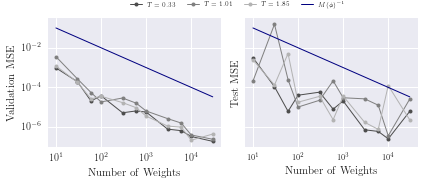

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(6,2.5), sharex=True, sharey=True)
fig.tight_layout()
for ax, res, error in zip(axes, [gs_results, test_results], ['Validation', 'Test']):
    for t, c in zip(T, ['0.3', '0.5', '0.7']):
        ax.plot(res[t]['Weights'], res[t]['{} MSE'.format(error)], '-o', c=c, mfc=c, mec=c, markersize=4, lw=1,
                label='$T = {}$'.format(t))
    ax.plot(res[1.01]['Weights'], 1 / res[1.01]['Weights'], c='navy', lw=1, label='$M(\phi)^{-1}$')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('Number of Weights')
    ax.set_ylabel('{} MSE'.format(error))
handles, labels = axes[1].get_legend_handles_labels()
ax.tick_params(axis='both', which='major', labelsize=8)
fig.legend(handles, labels, loc=[0.3,0.94], ncol=4, prop={'size': 6})
plt.tight_layout()
plt.savefig(plot_path + 'one_dim_AMZN_results.pdf')

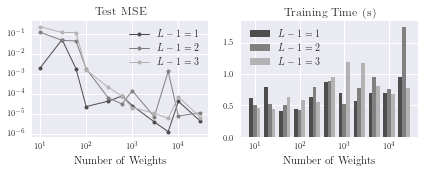

In [26]:
# Plot averaged training/test results

res_avg = get_averaged_overviews(['AMZN'], dim='one', T=[0.33, 1.01, 1.85])
plot_averaged_training(res_avg, 'one', 'market')

In [27]:
# Print all results for latex

for res_dict, name in zip([gs_results, test_results], ['Validation Results', 'Test Results']):
    print(name)
    for t in res_dict.keys():
        print('T = {}\n'.format(t))
        result_to_latex(res_dict[t])
        print('\n')
print('Averaged Results\n')
for hidden in [1, 2, 3]:
    print('L - 1 = {}\n'.format(hidden))
    result_to_latex(res_avg[hidden], resize=False)
    print('\n')

Validation Results
T = 0.33

\centering
\resizebox{\columnwidth}{!}{%
\begin{tabular}{r|llllll}
\toprule
 Weights & Validation MSE &  Hidden Layers & Learning Rate &  Batch Size &  Epochs & Training Time (s) \\
\midrule
      10 & \num{9.67e-04} &              1 &           0.1 &          16 &      25 &              1.49 \\
      30 & \num{1.92e-04} &              1 &          0.01 &           8 &     100 &              3.42 \\
      60 & \num{2.04e-05} &              1 &           0.1 &          16 &      25 &              1.41 \\
     100 & \num{3.80e-05} &              1 &           0.1 &          16 &      50 &              1.61 \\
     300 & \num{5.23e-06} &              3 &          0.01 &          64 &     150 &              2.09 \\
     600 & \num{6.48e-06} &              3 &         0.001 &           8 &     150 &              6.16 \\
    1000 & \num{5.71e-06} &              3 &         0.001 &           8 &     150 &              6.54 \\
    3000 & \num{7.82e-07} &           

C:\Users\oli-w\AppData\Local\Temp/ipykernel_22452/4495397.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  s = result_df.to_latex(escape=False, index=False, column_format='r|' + 'l' * (len(result_df.columns) - 1))





Test Results
T = 0.33

\centering
\resizebox{\columnwidth}{!}{%
\begin{tabular}{r|llllll}
\toprule
 Weights &       Test MSE &  Hidden Layers & Learning Rate &  Batch Size &  Epochs (Early Stop) & Training Time (s) \\
\midrule
      10 & \num{3.14e-03} &              1 &           0.1 &          16 &                   10 &              0.46 \\
      30 & \num{1.09e-04} &              1 &          0.01 &           8 &                  106 &              1.51 \\
      60 & \num{6.17e-06} &              1 &           0.1 &          16 &                   24 &              0.56 \\
     100 & \num{4.03e-05} &              1 &           0.1 &          16 &                   19 &              0.41 \\
     300 & \num{5.73e-05} &              3 &          0.01 &          64 &                   60 &              0.50 \\
     600 & \num{7.99e-06} &              3 &         0.001 &           8 &                   81 &              1.45 \\
    1000 & \num{2.07e-05} &              3 &         0.0